In [ ]:
!pip install --upgrade tensorflow==1.15

     |████████████████████████████████| 412.3MB 41kB/s 
     |████████████████████████████████| 512kB 36.9MB/s 
     |████████████████████████████████| 3.8MB 37.0MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7557 sha256=3dd10e58729f8f72a1999c1034e61c06d0828cc1c9e71f2e4509a78537f83478
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
ERROR: kapre 0.3.5 has requirement tensorflow>=2.0.0, but you'll have tensorflow 1.15.0 which is incompatible.
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0


In [ ]:
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


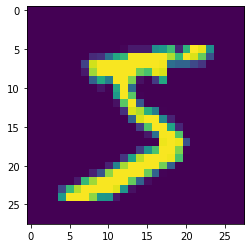

In [ ]:
plt.imshow(x_train[0])

In [ ]:
y_train = y_train.reshape([-1, 1])
y_test = y_test.reshape([-1, 1])

In [ ]:
encoder = OneHotEncoder(sparse=False)
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

In [ ]:
# Image
x_train = x_train.reshape([-1, 28, 28, 1])
x_test = x_test.reshape([-1, 28, 28, 1])

In [ ]:
x_train = x_train / 255.0
x_test = x_test / 255.0

In [ ]:
# Model
# out_channel = n_filters / n_kernel
def conv2d(x, out_channel, kernel_size, strides=1, padding="SAME"): # default padding --> auto
    in_channel = x.shape[-1]

    #Weight == Filter
    kernel = tf.Variable(
        tf.random.normal([kernel_size, kernel_size, in_channel, out_channel])
    )
    bias = tf.Variable(
        tf.random.normal([out_channel])
    )

    out = tf.nn.conv2d(x, kernel, strides=strides, padding=padding) + bias
    return tf.nn.relu(out)


In [ ]:
def dense(x, neuron_size, activation=None):
    in_shape = x.shape[-1]

    #Weight == Filter
    weight = tf.Variable(
        tf.random.normal([in_shape, neuron_size])
    )
    bias = tf.Variable(
        tf.random.normal([neuron_size])
    )

    out = tf.matmul(x, weight) + bias
    
    if activation is None:
        return out
    
    return activation(out)

In [ ]:
# Forward Propagation
input_placeholder = tf.placeholder(
    tf.float32, [None, 28, 28, 1]
)

label_placeholder = tf.placeholder(
    tf.float32, [None,10]
)

In [ ]:
# Conv1
out_conv1 = conv2d(input_placeholder, 8, 3)
pooled1 = tf.nn.max_pool2d(out_conv1, 2, 2, padding="SAME")

# Conv2
out_conv2 = conv2d(input_placeholder, 16, 3)
pooled2 = tf.nn.max_pool2d(out_conv2, 2, 2, padding="SAME")

In [ ]:
# Training
def accuracy_score(y_true, y_predict):
    matches = tf.equal(
        tf.argmax(y_true, 1), # [0, 1, 0] = 1
        tf.argmax(y_predict, 1) # [1, 0, 0] = 0
    )
    return tf.reduce_mean(tf.cast(matches, tf.float32))

In [ ]:
def get_batch(iteration, x, y, batch_size):
    start_idx = iteration * batch_size
    data_len = x_train.shape[0]
    
    yield x[start_idx : min(start_idx + batch_size, data_len)]
    yield y[start_idx : min(start_idx + batch_size, data_len)]
    # yield akan return, tapi ga akan selesain fungsinya

In [ ]:
def flatten(x):
    size = 1

    shape = x.shape[1:]
    for s in shape:
        size *= s
    
    return tf.reshape(x, [-1, size])

In [ ]:
#FC
flattened = flatten(pooled2)
output_tensor = dense(flattened, 10)

In [ ]:
loss_tensor = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(
        logits=output_tensor,
        labels=label_placeholder
    )
)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [ ]:
optimizer = tf.train.AdamOptimizer(0.01)
train = optimizer.minimize(loss_tensor)

In [ ]:
num_epochs = 10
batch_size = 512
iter_len = x_train.shape[0] // batch_size # pertama dibagi, terus di floor() -- round ke bawah
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for epoch in range(num_epochs):
        print("")
        print(f"Epoch {epoch+1} / {num_epochs}")
        print("--")
        for iteration in range(iter_len):
            x_batch, y_batch = get_batch(iteration, x_train, y_train, batch_size)

            train_dict = {
                input_placeholder: x_train,
                label_placeholder: y_train
            }

            sess.run(train, feed_dict=train_dict)

            loss = sess.run(loss_tensor, feed_dict=train_dict)
            acc = sess.run(
                accuracy_score(label_placeholder, output_tensor),
                feed_dict=train_dict
            )

            if iteration % 10 == 0:
                print(f"{iteration}/{iter_len} - loss {loss:.4f} - acc {acc:.4f}")
            
        
        test_dict = {
            input_placeholder: x_test,
            label_placeholder: y_test
        }

        val_loss = sess.run(loss_tensor, feed_dict=train_dict)
        val_acc = sess.run(
            accuracy_score(label_placeholder, output_tensor),
            feed_dict=test_dict
        )       
        

        print("--")
        print("Validation Loss: ", val_loss)
        print("Validation Accuracy: ", val_acc)

            
# cepet banget gakuat jari w



Epoch 1 / 10
--
0/117 - loss 83.7603 - acc 0.0728
10/117 - loss 37.4545 - acc 0.1543
20/117 - loss 20.0512 - acc 0.3423
30/117 - loss 10.4022 - acc 0.5677
40/117 - loss 6.2318 - acc 0.7041
50/117 - loss 4.3360 - acc 0.7812
60/117 - loss 3.3448 - acc 0.8194
70/117 - loss 2.7377 - acc 0.8450
80/117 - loss 2.3112 - acc 0.8622
90/117 - loss 1.9958 - acc 0.8759
100/117 - loss 1.7503 - acc 0.8851
110/117 - loss 1.5489 - acc 0.8934
--
Validation Loss:  1.4437544
Validation Accuracy:  0.9037

Epoch 2 / 10
--
0/117 - loss 1.4273 - acc 0.8990
10/117 - loss 1.2781 - acc 0.9059
20/117 - loss 1.1549 - acc 0.9124
30/117 - loss 1.0517 - acc 0.9175
40/117 - loss 0.9640 - acc 0.9220
50/117 - loss 0.8885 - acc 0.9261
60/117 - loss 0.8229 - acc 0.9293
70/117 - loss 0.7665 - acc 0.9327
80/117 - loss 0.7180 - acc 0.9359
90/117 - loss 0.6758 - acc 0.9382
100/117 - loss 0.6389 - acc 0.9406
110/117 - loss 0.6062 - acc 0.9430
--
Validation Loss:  0.58830065
Validation Accuracy:  0.9361

Epoch 3 / 10
--
0/117 